# MERFISH whole brain spatial transcriptomics cells with imputed genes

In the MERFISH tutorial (part 1), we discussed how each cell form the MERFISH data was mapped to the whole mouse brain taxonomy using a hierarchical correlation method. To further integrate the transcriptomics and spatial profiles of each cell type, 10Xv3 expression was projected or imputed into the MERFISH space. The basic idea is to compute the k-nearest neighbors (KNNs) among the 10Xv3 cells for each MERFISH cell and use the average expression of these neighbors for each gene as the impute values. Imputed expression values were generated for 8,460 marker genes. Further details can be found in the methods section of [Yao et. al](https://www.nature.com/articles/s41586-023-06812-z).

In this notebook, we will show the basics on how to access the imputed gene data and perform some illustrative comparison between expression 10X, MERFISH measured and impute expression similar to [Extended Data Fig 8](https://www.nature.com/articles/s41586-023-06812-z/figures/14) in the manuscript.

You need to be connected to the internet to run this notebook and have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241115/manifest.json'

Download and read in the expanded cell metadata table. This is the same as what is created by the in [part 1 of the MERFISH tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/merfish_tutorial_part_1.html). This is the cell metadata table joined with all cluster annotation information.

In [3]:
cell = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='cell_metadata_with_cluster_annotation',
    dtype={"cell_label": str,
           "neurotransmitter": str}
)
cell.set_index('cell_label', inplace=True)

cell_metadata_with_cluster_annotation.csv: 100%|█████████████████████████████████████████████| 1.02G/1.02G [00:47<00:00, 21.3MMB/s]


Load the imputed data. Here we use 3 genes used in the comparison shown in the paper [here](https://www.nature.com/articles/s41586-023-06812-z/figures/14).

In [4]:
imputed_h5ad_path = abc_cache.get_data_path('MERFISH-C57BL6J-638850-imputed', 'C57BL6J-638850-imputed/log2')
adata = anndata.read_h5ad(imputed_h5ad_path, backed='r')
gene_list = ['Calb2', 'Baiap3', 'Lypd1']

C57BL6J-638850-imputed-log2.h5ad: 100%|██████████████████████████████████████████████████████| 50.2G/50.2G [38:49<00:00, 21.6MMB/s]


Next we map our gene symbols to ENSEMBL ids. The anndata files store genes as ENSEMBL ids to prevent ambiguty with gene symbols.

In [5]:
pred = [x in gene_list for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

gene_symbol
gene_identifier               
ENSMUSG00000026344       Lypd1
ENSMUSG00000047507      Baiap3
ENSMUSG00000003657       Calb2

Now that we have the ENSEMBL ids, we can select the desired imputed genes. Note that this is one of the few gene expression datasets in the ABC Atlas dataset that is stored as a dense matrix in a single file. We can thus slice by gene index instead of a more complicated access pattern as seen in the other 10X and MERFISH tutorials.

In [6]:
gene_subset = adata[:, gene_filtered.index].to_df()
adata.file.close()
del adata

gene_subset.rename(columns=gene_filtered.to_dict()['gene_symbol'], inplace=True)
gene_subset

/allen/aibs/informatics/chris.morrison/miniconda/envs/abc_atlas_access/lib/python3.11/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


gene_identifier           Lypd1    Baiap3     Calb2
cell_label                                         
1104095349100540743-1  4.195312  0.248901  0.203247
1018093345100600265    4.437500  0.313721  0.277344
1018135614102090183    4.277344  0.283936  0.253662
1104095348100570634    4.250000  0.271973  0.211670
1018122109102452991    4.472656  0.247437  0.208130
...                         ...       ...       ...
1018093344102210157-1  0.312500  0.327148  0.095215
1017155956101850294    0.226562  0.290039  0.517578
1017184920101480142    0.394043  0.532227  0.483887
1019171912101210584    1.333008  0.102417  0.000000
1104095349101490383    1.375000  0.211182  0.032928

[4334174 rows x 3 columns]

Now that our selected genes are in a single dataframe, indexed by cell_label, we can merge them into our cell metadata table.

In [7]:
joined = cell.join(gene_subset, on='cell_label')

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory. Note that this is a simple wrapper of the Pandas GroupBy functionality. Other summary statistics beyond just the `mean` are listed here: https://pandas.pydata.org/docs/reference/groupby.html#dataframegroupby-computations-descriptive-stats

In [8]:
def aggregate_by_metadata(df, gnames, value, sort=False) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Visualize imputed gene expression for selected genes.

In this example, we create a dataframe comprising of expression of the our 3 selected genes for all the cells in the dataset. We can group the cells by various different metadata. For example, grouping expression by brain sections shows that each of these genes have distinct spatial patterns. The MERFISH data allows us to visualize these patterns in anatomical context.

In [9]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r, vmin=0, vmax=None, title=None):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)

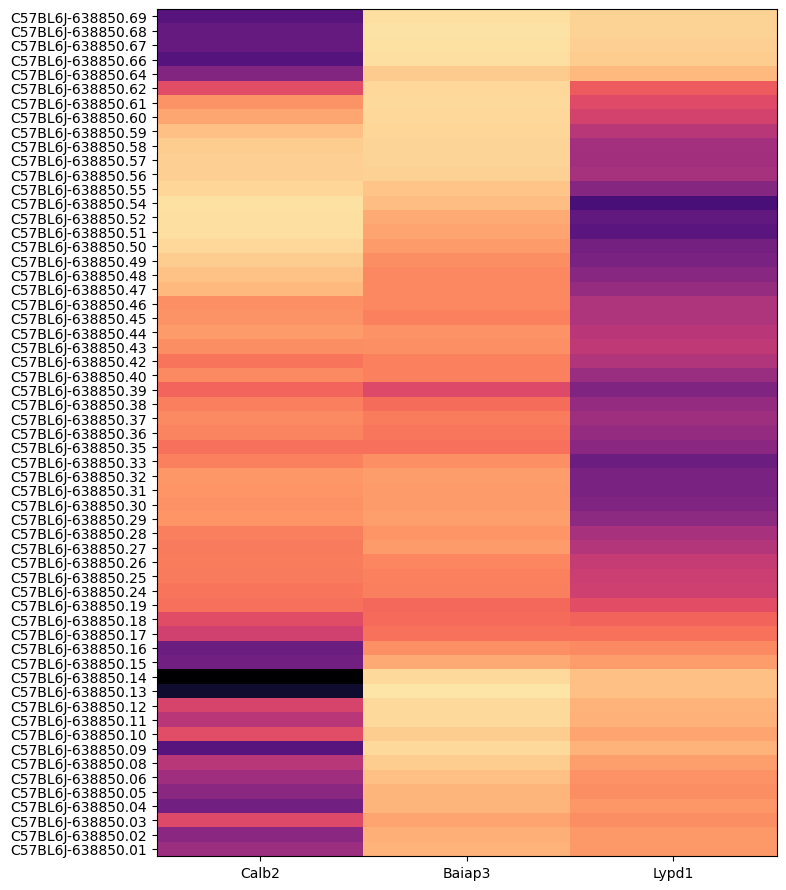

In [10]:
agg = aggregate_by_metadata(joined, gene_list, 'brain_section_label')
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg, 8, 11)
plt.show()

We define a helper function *plot_sections* to visualize the cells for a specified set of brain sections either by colorized metadata or gene expression.

In [11]:
def plot_sections(df, feature, blist, cmap = None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist):
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0, 11)
        ax[idx].set_ylim(11, 0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl))
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax
    

We will use the aggregate by brain section table above to pick a four sections of interest and plot cells in those sections by their expression of each of the selected imputed genes.

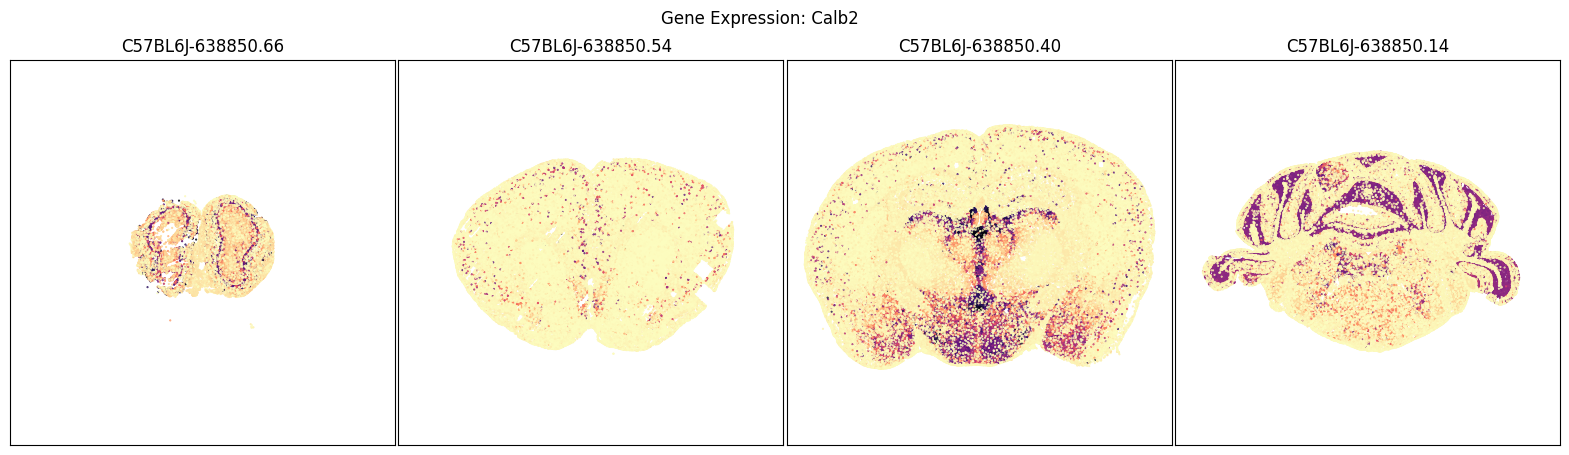

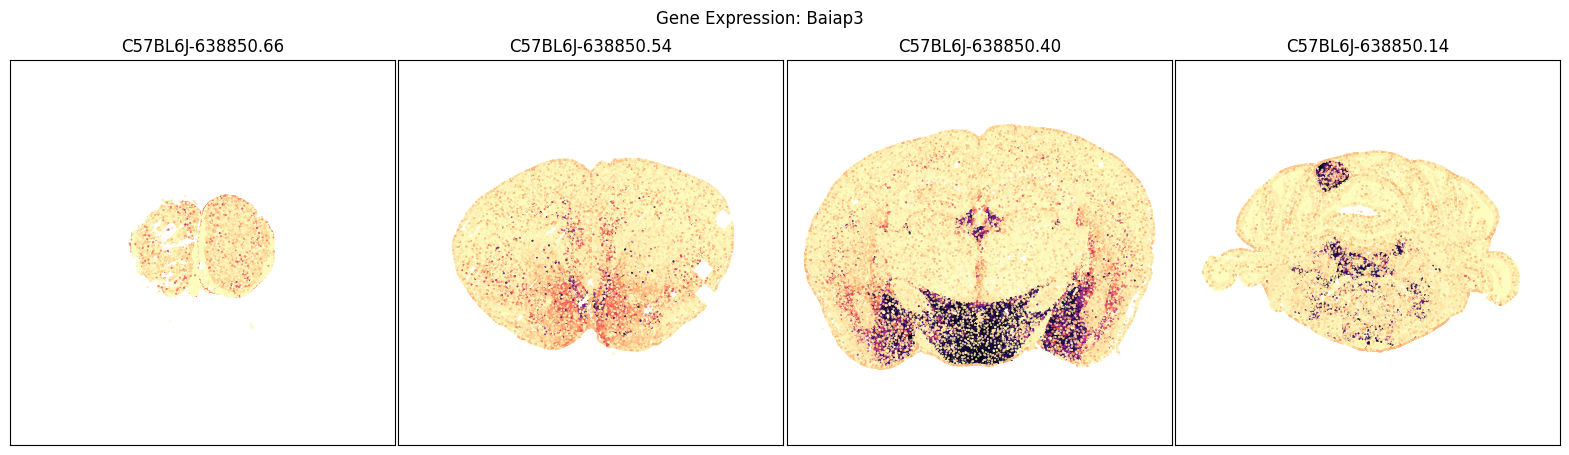

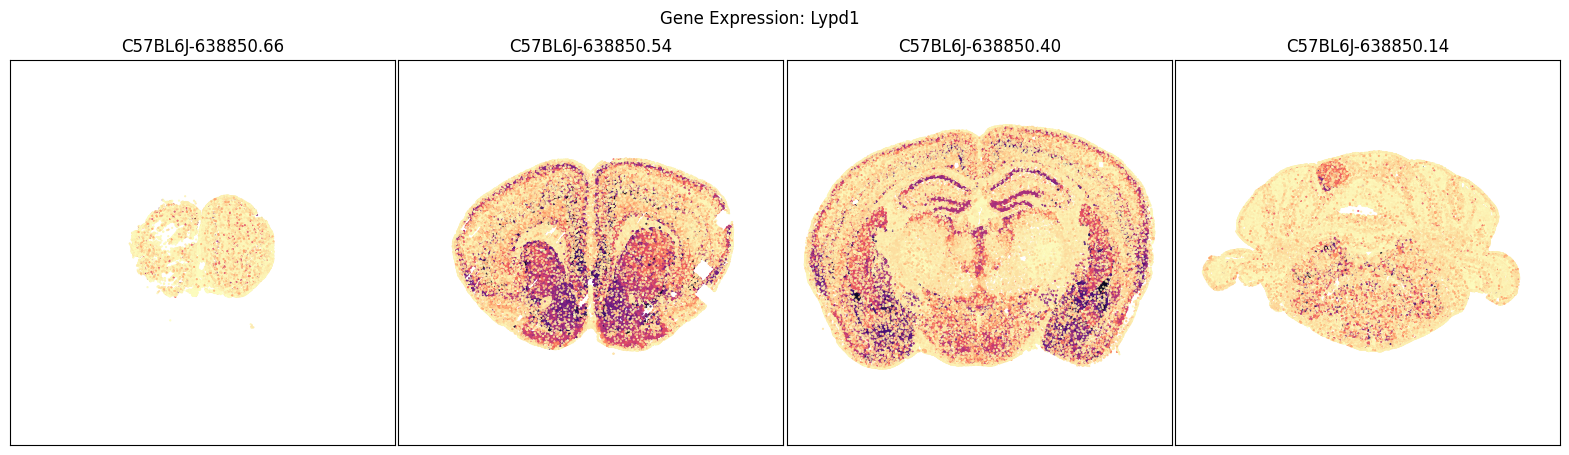

In [12]:
blist = ['C57BL6J-638850.66', 'C57BL6J-638850.54', 'C57BL6J-638850.40', 'C57BL6J-638850.14']
for gene_symbol in gene_list:
    fig, ax = plot_sections(joined, gene_symbol, blist, cmap=plt.cm.magma_r)
    fig.suptitle(f'Gene Expression: {gene_symbol}')
    plt.show()

## Comparison of imputed genes to measured genes across the brain

In this next section, perform some illustrative comparison between MERFISH measured and impute expression similar to Extended [Data Fig 8](https://www.nature.com/articles/s41586-023-06812-z/figures/14) in the manuscript.

We follow the [2a MERFISH tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/merfish_tutorial_part_2a.html) to extract the same 3 genes from the measured MERFISH dataset.

In [13]:
merfish_file = abc_cache.get_data_path(
    directory='MERFISH-C57BL6J-638850',
    file_name='C57BL6J-638850/log2'
)
mer_adata = anndata.read_h5ad(merfish_file, backed='r')
mer_gene_subset = mer_adata[:, gene_filtered.index].to_df()
mer_gene_subset.rename(columns=gene_filtered.to_dict()['gene_symbol'], inplace=True)
mer_gene_subset

gene_identifier         Lypd1    Baiap3     Calb2
cell_label                                       
1015221640100570419  1.544775  0.000000  0.000000
1015221640100590598  2.292181  0.000000  0.000000
1015221640100820600  0.000000  1.180946  0.000000
1015221640100580476  0.000000  0.000000  0.000000
1015221640100580189  0.000000  0.000000  1.441020
...                       ...       ...       ...
1018145707100250222  0.000000  0.000000  1.903645
1018145707100250185  0.000000  0.000000  0.693273
1018145707100430302  0.000000  1.052222  0.000000
1018145707100430291  0.000000  0.000000  0.000000
1018145707100390249  0.000000  0.000000  1.384842

[4334174 rows x 3 columns]

Again, we lookup the gene ENSEMBL id using the gene symbol.

Next we join the measured MERFISH genes into the cell metadata table. We then extract the same genes from the imputed dataset and again join it into the cell metadata. The imputed genes will have the same gene symbol but with an added `_imp` in the game (e.g. Calb2_imp).

In [14]:
joined = cell.join(mer_gene_subset)
joined = joined.join(gene_subset, on='cell_label', rsuffix='_imp')

### Measured vs imputed MERFISH expression (spatial view)

Finally, we define a variant plot_section function that allows us to plot gene expression for the measured and imputed data side-by-side for each section. Again this shows good agreement between the imputed and measured MERFISH genes.

In [15]:
def plot_section_compraison(df, feature, blist, cmap = None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1, 2 * len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for section_idx, bsl in enumerate(blist):
        meas_idx = 2 * section_idx
        imputed_idx = 2 * section_idx + 1
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']
        measured_value = filtered[feature]
        imputed_value = filtered[feature + '_imp']

        # Enforce the same color min/max between imputed and measured plots.
        min_value = min([measured_value.min(), imputed_value.min()])
        max_value = min([measured_value.max(), imputed_value.max()])
        norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)
        
        if cmap is not None :
            ax[meas_idx].scatter(xx, yy, s=1.0, c=norm(measured_value), marker='.', cmap=cmap)
            ax[imputed_idx].scatter(xx, yy, s=1.0, c=norm(imputed_value), marker='.', cmap=cmap)
        else :
            ax[meas_idx].scatter(xx, yy, s=1.0, color=measured_value, marker=".")
            ax[imputed_idx].scatter(xx, yy, s=1.0, color=imputed_value, marker=".")

        for axis_idx in [meas_idx, imputed_idx]:
            ax[axis_idx].axis('equal')
            ax[axis_idx].set_xlim(0, 11)
            ax[axis_idx].set_ylim(11, 0)
            ax[axis_idx].set_xticks([])
            ax[axis_idx].set_yticks([])

        ax[meas_idx].set_title("%s [measured]" % (bsl))
        ax[imputed_idx].set_title("%s [imputed]" % (bsl))
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

Below we compare the measure versus imputed genes for there different brain sections.

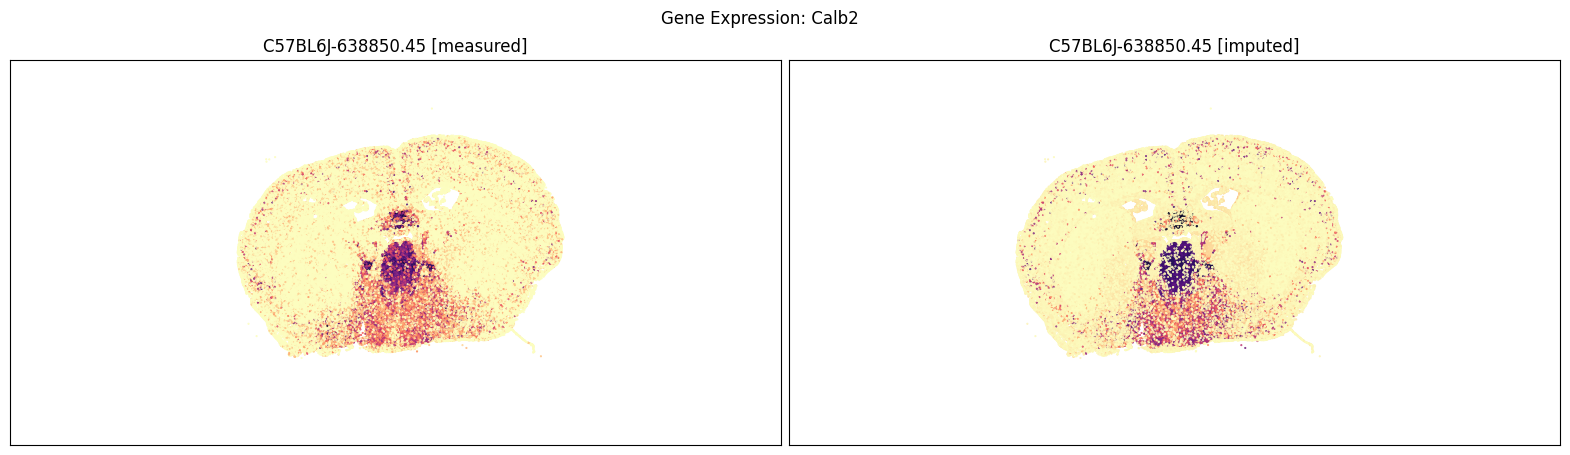

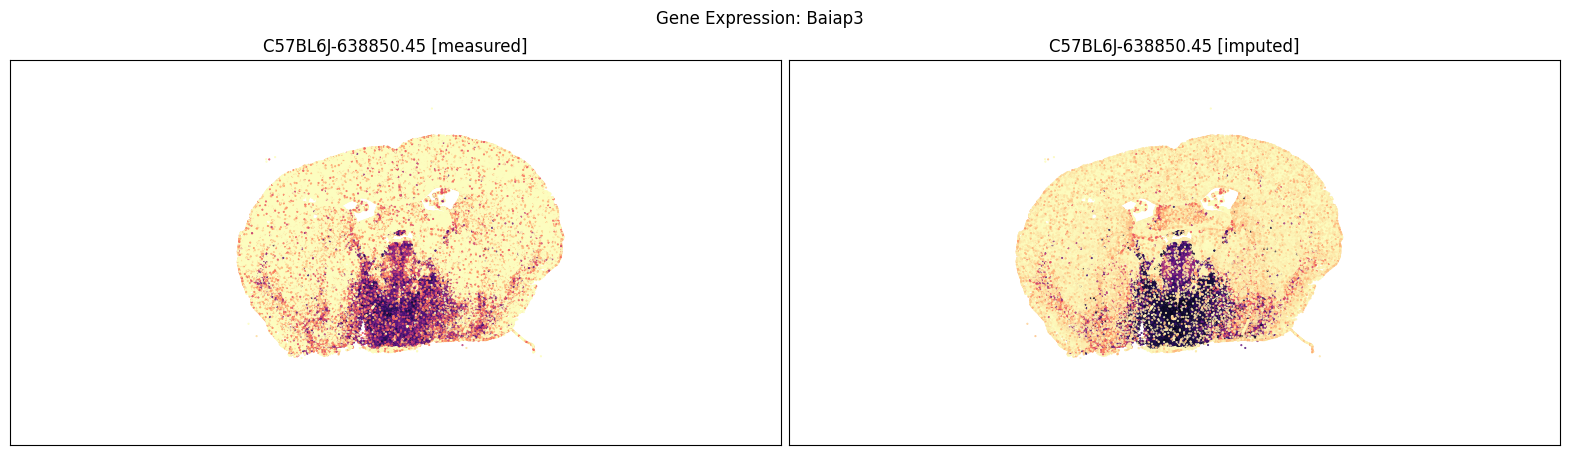

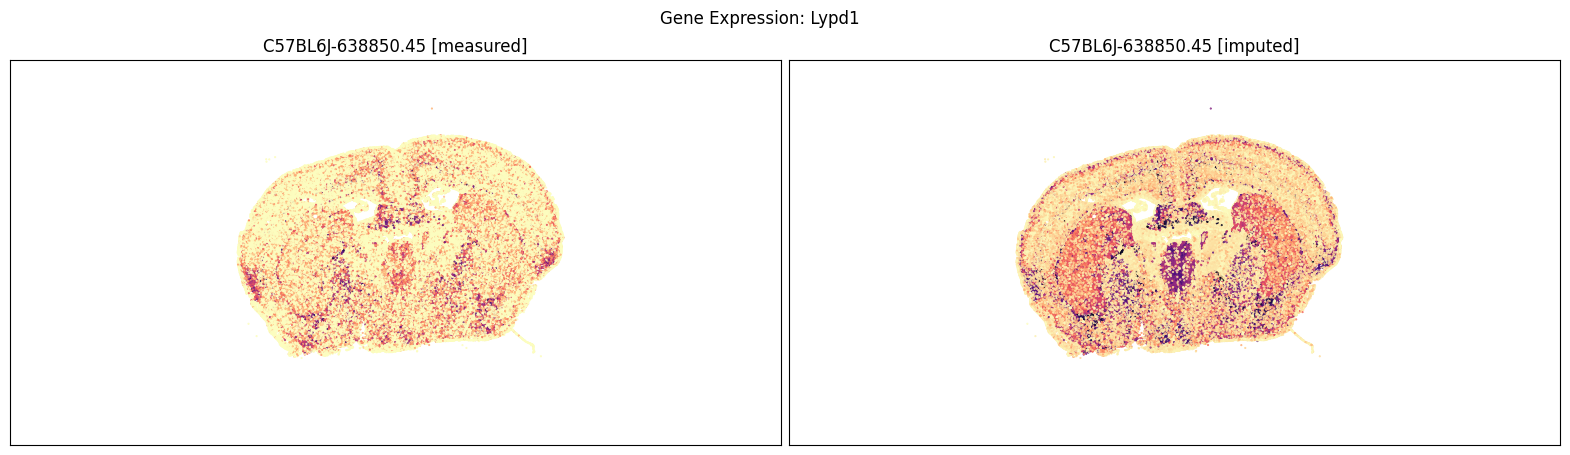

In [16]:
blist = ['C57BL6J-638850.45']
for gene_symbol in ['Calb2', 'Baiap3', 'Lypd1']:
    fig, ax = plot_section_compraison(joined, gene_symbol, blist, cmap=plt.cm.magma_r)
    fig.suptitle(f'Gene Expression: {gene_symbol}')
    plt.show()

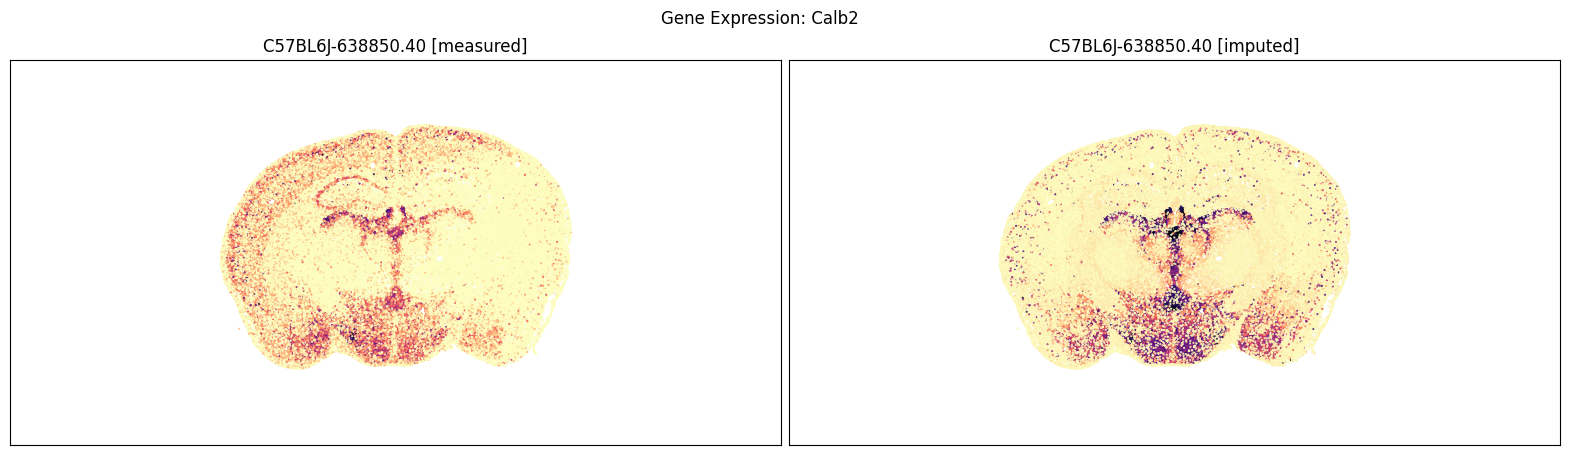

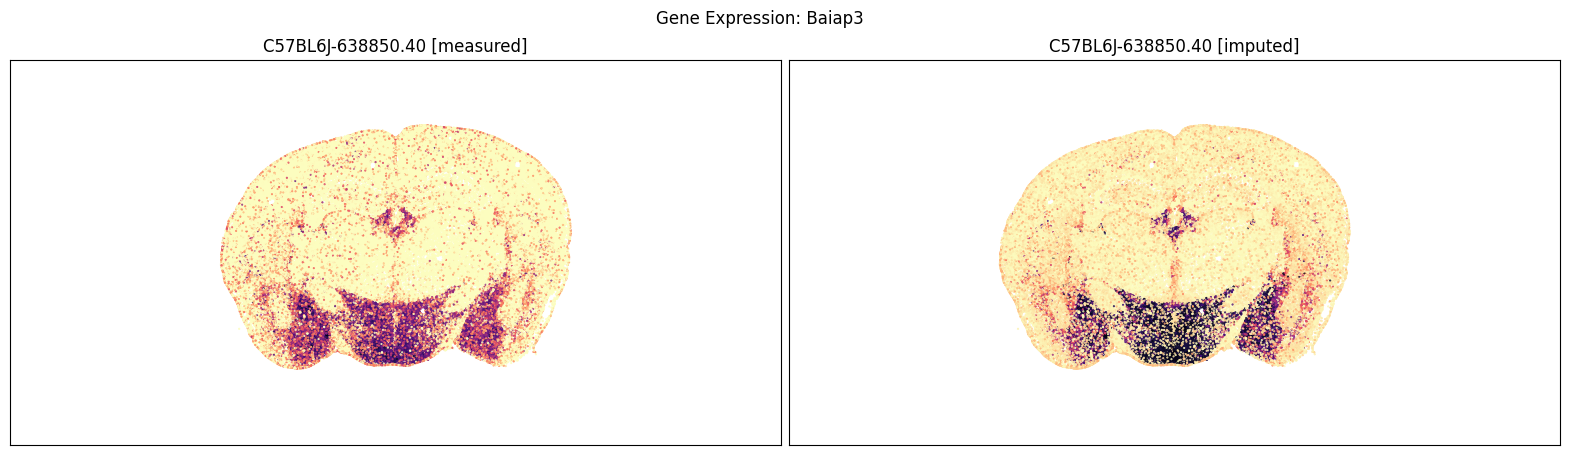

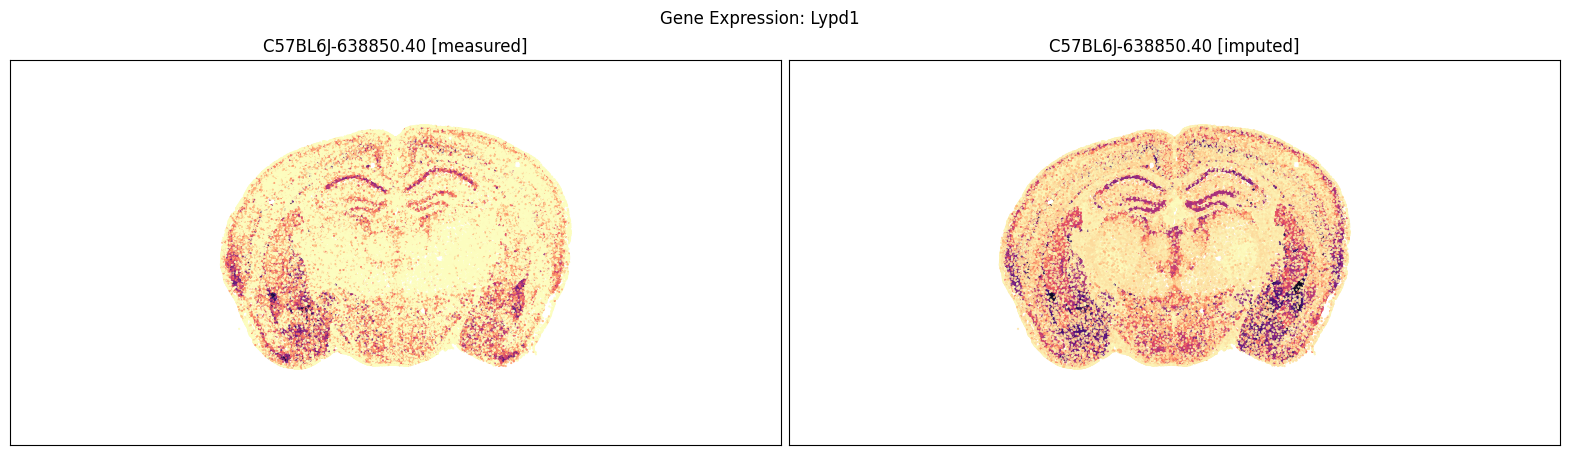

In [17]:
blist = ['C57BL6J-638850.40']
for gene_symbol in ['Calb2', 'Baiap3', 'Lypd1']:
    fig, ax = plot_section_compraison(joined, gene_symbol, blist, cmap=plt.cm.magma_r)
    fig.suptitle(f'Gene Expression: {gene_symbol}')
    plt.show()

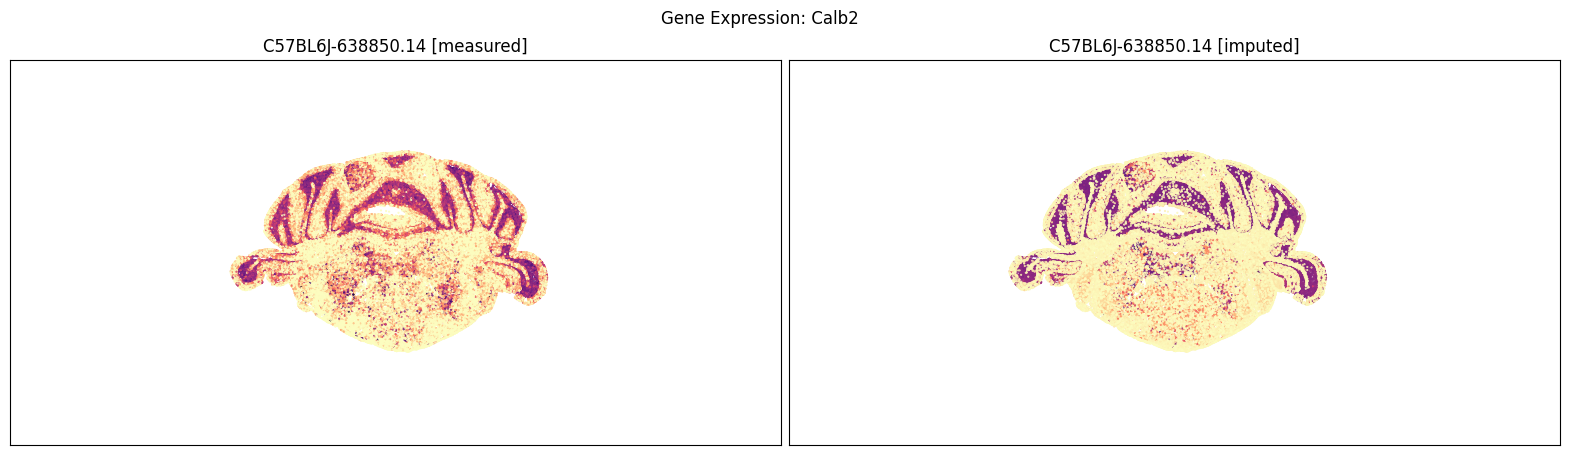

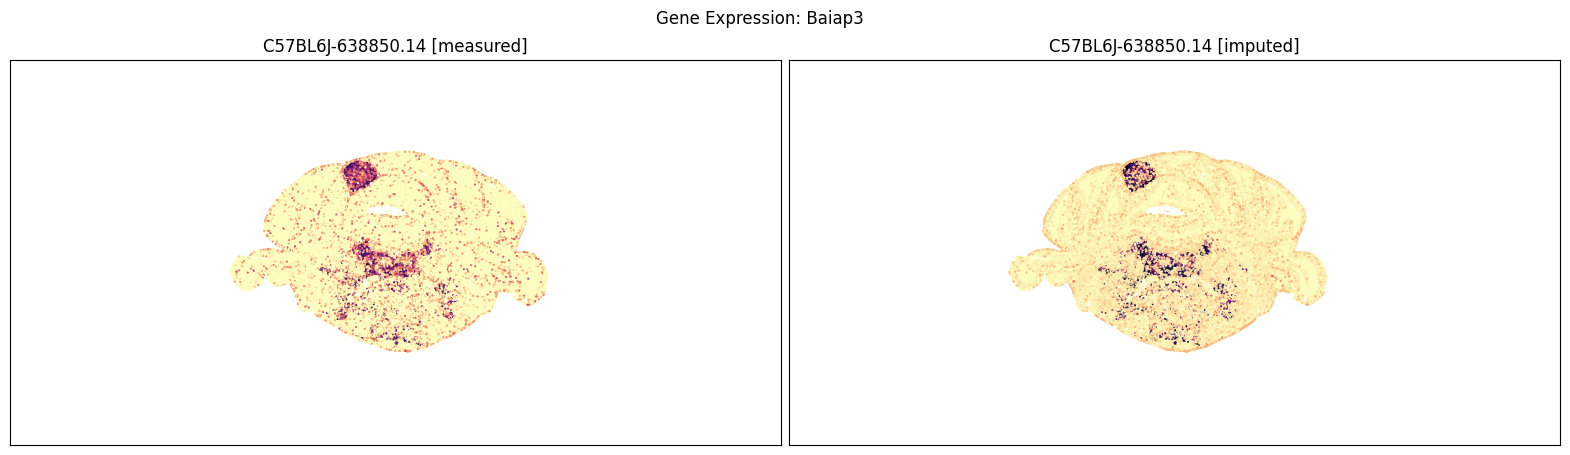

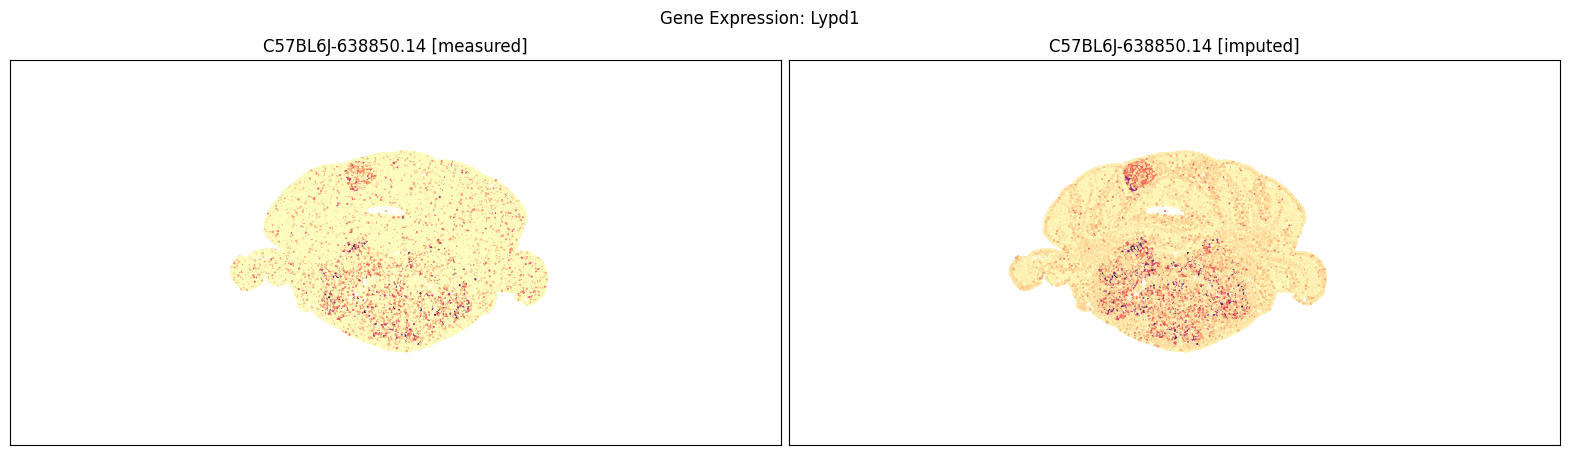

In [18]:
blist = ['C57BL6J-638850.14']
for gene_symbol in ['Calb2', 'Baiap3', 'Lypd1']:
    fig, ax = plot_section_compraison(joined, gene_symbol, blist, cmap=plt.cm.magma_r)
    fig.suptitle(f'Gene Expression: {gene_symbol}')
    plt.show()

### Measured vs impute MERFISH expression (cluster level correlation

We plot the expression of the MERFISH data as a function of the imputed gene expression. We average the expression of both sets of genes by the 5k clusters in the taxonomy. The plots below show good agreement between the measured and imputed expressions. 

In [19]:
clust_means = joined.groupby(['cluster'])[['Calb2', 'Baiap3', 'Lypd1', 'Calb2_imp', 'Baiap3_imp', 'Lypd1_imp']].mean()
print(len(clust_means))

5320


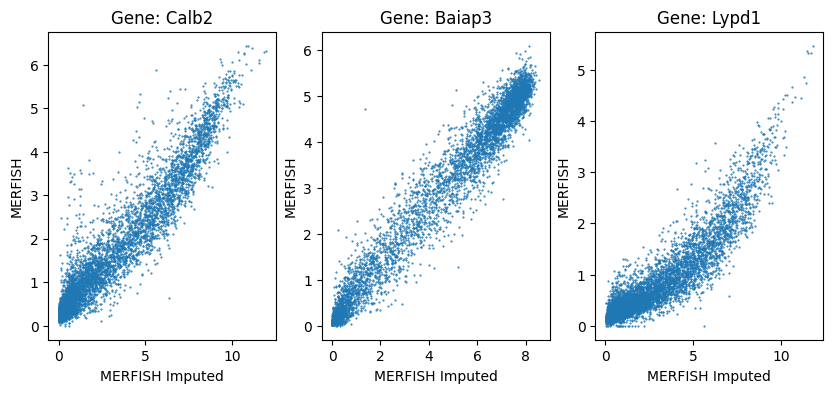

In [20]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(10, 4)
for idx, gene in enumerate(['Calb2', 'Baiap3', 'Lypd1']):
    ax[idx].scatter(clust_means[f'{gene}_imp'], clust_means[gene], s=1.0, marker='.', alpha=1)
    ax[idx].set_xlabel('MERFISH Imputed')
    ax[idx].set_ylabel('MERFISH')
    ax[idx].set_title(f'Gene: {gene}')
plt.show()